In [1]:
# Import library yang dibutuhkan
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import time

In [6]:
# 1. Persiapan Data CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dataloader untuk batching data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:08<00:00, 20.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# 2. Definisikan model CNN dengan variasi kernel dan pooling
class CNNModel(nn.Module):
    def __init__(self, kernel_size=3, pooling='max'):
        super(CNNModel, self).__init__()
        # Memilih pooling (MaxPooling atau AveragePooling)
        pool_layer = nn.MaxPool2d if pooling == 'max' else nn.AvgPool2d

        # Layer konvolusi pertama
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.pool1 = pool_layer(2, 2)

        # Layer konvolusi kedua
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.pool2 = pool_layer(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))  # Konvolusi pertama diikuti pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Konvolusi kedua diikuti pooling
        x = x.view(-1, 64 * 8 * 8)               # Flatten tensor untuk fully connected layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
# 3. Fungsi Training dan Evaluasi Model
def train_model(model, train_loader, optimizer, criterion, scheduler=None, early_stop_patience=10, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_loss = float('inf')
    patience = 0
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradien optimizer
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update bobot

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        if scheduler:
            scheduler.step(epoch_loss)  # Update learning rate jika menggunakan scheduler

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

        # Early Stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print("Early stopping triggered")
                break

    return train_losses

def evaluate_model(model, test_loader, criterion):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return test_loss, accuracy


Training model with parameters: {'epochs': 5, 'kernel_size': 3, 'optimizer': 'SGD', 'pooling': 'max'}
Epoch 1/5, Loss: 2.0490
Epoch 2/5, Loss: 1.6658
Epoch 3/5, Loss: 1.4731
Epoch 4/5, Loss: 1.3499
Epoch 5/5, Loss: 1.2653
Test Loss: 1.3153, Accuracy: 53.57%
Training model with parameters: {'epochs': 5, 'kernel_size': 3, 'optimizer': 'SGD', 'pooling': 'avg'}
Epoch 1/5, Loss: 2.1633
Epoch 2/5, Loss: 1.8038
Epoch 3/5, Loss: 1.6578
Epoch 4/5, Loss: 1.5524
Epoch 5/5, Loss: 1.4696
Test Loss: 1.4601, Accuracy: 47.33%
Training model with parameters: {'epochs': 5, 'kernel_size': 3, 'optimizer': 'RMSProp', 'pooling': 'max'}
Epoch 1/5, Loss: 9.4435
Epoch 2/5, Loss: 1.5288
Epoch 3/5, Loss: 1.3706
Epoch 4/5, Loss: 1.2528
Epoch 5/5, Loss: 1.2787
Test Loss: 1.4018, Accuracy: 52.01%
Training model with parameters: {'epochs': 5, 'kernel_size': 3, 'optimizer': 'RMSProp', 'pooling': 'avg'}
Epoch 1/5, Loss: 6.8019
Epoch 2/5, Loss: 1.5826
Epoch 3/5, Loss: 1.3947
Epoch 4/5, Loss: 1.2065
Epoch 5/5, Loss: 1.1

KeyboardInterrupt: 

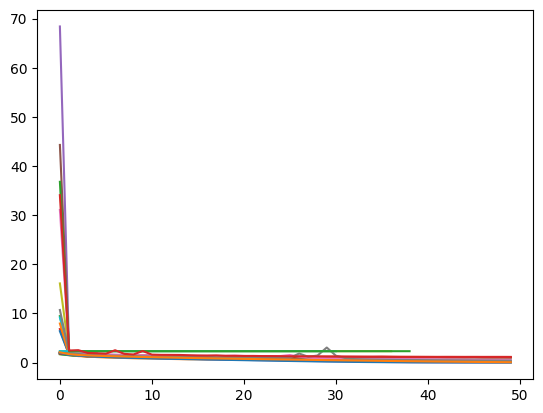

In [9]:
# 4. Eksperimen Parameter
params = {
    'kernel_size': [3, 5, 7],
    'pooling': ['max', 'avg'],
    'epochs': [5, 50, 100],
    'optimizer': ['SGD', 'RMSProp', 'Adam']
}

results = []
criterion = nn.CrossEntropyLoss()
param_grid = list(ParameterGrid(params))

for param in param_grid:
    print(f"Training model with parameters: {param}")

    # Definisikan model dan optimizer
    model = CNNModel(kernel_size=param['kernel_size'], pooling=param['pooling'])
    optimizer = optim.SGD(model.parameters(), lr=0.01) if param['optimizer'] == 'SGD' else (
                optim.RMSprop(model.parameters(), lr=0.01) if param['optimizer'] == 'RMSProp' else
                optim.Adam(model.parameters(), lr=0.01))

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)  # Scheduler untuk LR

    # Training model
    start_time = time.time()
    train_losses = train_model(model, train_loader, optimizer, criterion, scheduler=scheduler, epochs=param['epochs'])
    end_time = time.time()

    # Evaluasi model
    test_loss, accuracy = evaluate_model(model, test_loader, criterion)

    results.append({
        'params': param,
        'test_loss': test_loss,
        'accuracy': accuracy,
        'training_time': end_time - start_time
    })

    # Visualisasi training loss per epoch
    plt.plot(train_losses, label=f"{param}")

plt.legend()
plt.title("Training Loss per Experiment")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Tampilkan hasil eksperimen
import pandas as pd
results_df = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="Hasil Eksperimen CNN CIFAR10", dataframe=results_df)